<a href="https://colab.research.google.com/github/ekgren/StructuredDreaming/blob/main/colabs/Structured_Dreaming_Styledreams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured Dreaming - Styledream notebook
The Styledream notebook is a notebook for finetuning Stylegan2 models with CLIP.

Disclaimer: The underlying repository StructuredDreaming https://github.com/ekgren/StructuredDreaming will continually undergo changes that might break copies of this notebook.  

Author: Ariel Ekgren  
https://github.com/ekgren  
https://twitter.com/ArYoMo  

Resources:  
CLIP https://github.com/openai/CLIP  
Stylegan2 ADA https://github.com/NVlabs/stylegan2-ada-pytorch

In [1]:
!nvidia-smi

Sat Oct  2 15:50:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    41W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ftfy regex tqdm pyspng ninja imageio-ffmpeg==0.4.3
!git clone https://github.com/ekgren/StructuredDreaming.git
!pip install -e ./StructuredDreaming

!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'stylegan2-ada-pytorch')

fatal: destination path 'StructuredDreaming' already exists and is not an empty directory.
Obtaining file:///content/StructuredDreaming
  Attempting uninstall: structureddreaming
    Found existing installation: structureddreaming 0.0.1
    Can't uninstall 'structureddreaming'. No files were found to uninstall.
  Running setup.py develop for structureddreaming
fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


In [3]:
!git -C ./StructuredDreaming/ pull

Already up to date.


In [4]:
# Imports
import random
import torch
import torchvision
import PIL
from matplotlib import pyplot as pl
from IPython.display import clear_output

# StructuredDreaming imports
from StructuredDreaming import structure
from StructuredDreaming.structure import clip
from StructuredDreaming.structure import sample
from StructuredDreaming.structure import optim

# Stylegan imports
import dnnlib
import legacy

In [5]:
# Load models
perceptor, normalize_image = structure.clip.load('ViT-B/16', jit=False)

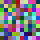

In [6]:
# Utils
def display_img(input: torch.Tensor, size: float = 1.):
    """ Assumes tensor values in the range [0, 1] """
    with torch.no_grad():
        batch_size, num_channels, height, width = input.shape
        img = torch.nn.functional.interpolate(input, (int(size*height), int(size*width)), mode='area')
        img_show = img.cpu()[0].transpose(0, 1).transpose(1, 2)
        img_out = (img_show * 255).clamp(0, 255).to(torch.uint8)
        display(PIL.Image.fromarray(img_out.cpu().numpy(), 'RGB'))
        pl.show()

def stylegan_to_rgb(input: torch.Tensor) -> torch.Tensor:
    return (input * 127.5 + 128) / 255

display_img(torch.rand(1, 3, 10, 10, requires_grad=False), 4)

In [7]:
#@title # Prompt and training parameters{ run: "auto" }
#@markdown Write your image prompt in the txt field below.

#@markdown Prompt suggestions:
#@markdown * "portrait painting of android from dystopic future by James Gurney"

txt = "portrait painting of neon gods by Into the Void" #@param {type:"string"}

# Training parameters
iterations = 300
grad_acc_steps = 1
batch_size = 1
lr = 5e-4
loss_scale = 100.
steps_show = 32
truncation_psi = 0.6
clamp_val = 1e-30

# Sampler
kernel_min = 1
kernel_max = 8

network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'

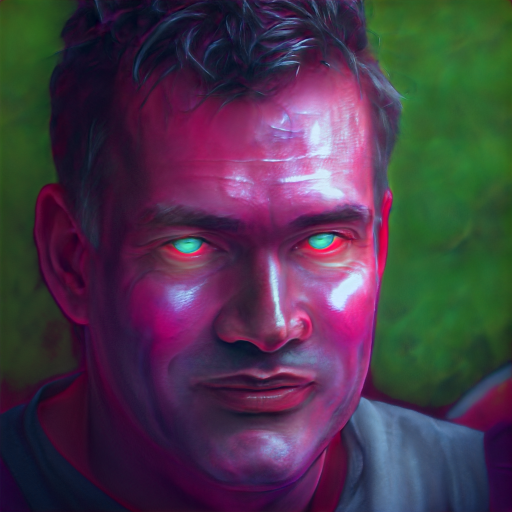

287 -36.09375 -0.08834360539913177 1.094140648841858


In [8]:
#@title Train loop {vertical-output: true}
#@markdown Loading and fine-tuning the model.

device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
for p in G.parameters():
    p.requires_grad = True
c = None

# Training
txt_tok = structure.clip.tokenize(txt)
text_latent = perceptor.encode_text(txt_tok.to(device)).detach()
sampler = torch.jit.script(
              structure.sample.ImgSampleStylegan(kernel_min=kernel_min,
                                                 kernel_max=kernel_max).to(device)
          )
optimizer = structure.optim.ClampSGD(list(G.parameters()),
                                     lr=lr, 
                                     clamp=clamp_val)

im_no = 0
print('Generating image.')
for i in range(iterations):

    if (i + 1) % steps_show == 0:
        with torch.no_grad():
            clear_output(True)
            z = torch.randn([1, G.z_dim], device=device)          
            img = G(z, c, truncation_psi)
            img = stylegan_to_rgb(img)
            display_img(img, 0.5)
            print(i, 
                  loss.item(),
                  img.min().item(), 
                  img.max().item(),) 
            im_no += 1
    
    for j in range(grad_acc_steps):
        optimizer.zero_grad()
        z = torch.randn([1, G.z_dim], device=device)
        img = G(z, c, truncation_psi)
        img = stylegan_to_rgb(img)
        img = sampler(img, size=224, bs=batch_size)
        img = normalize_image(img)
        img_latents = perceptor.encode_image(img)
        loss = torch.cosine_similarity(text_latent, img_latents, dim=-1).mean().neg() * loss_scale
        
        loss.backward()

    optimizer.step()

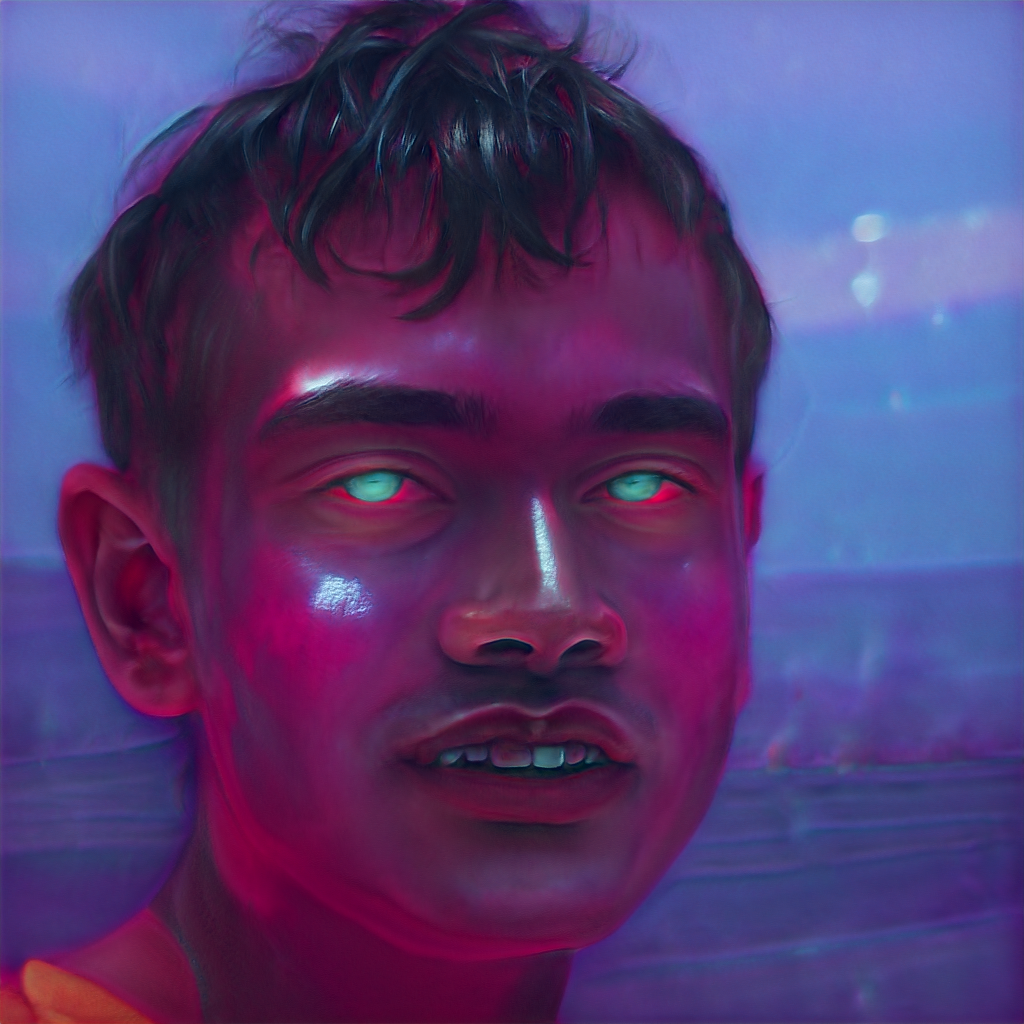

In [59]:
#@title Generate images from the fine-tuned model

with torch.no_grad():
    clear_output(True)
    z = torch.randn([1, G.z_dim], device=device)
    img = G(z, c, truncation_psi)
    img = stylegan_to_rgb(img)
    display_img(img, 1.)